IMAGE CAPTION GENERATOR 
BY YUVRAJ DALVI DF 2204

In [ ]:
#Importing all necessary libraries

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
#tqdm is a library in Python which is used for creating Progress Meters or Progress Bars
#tqdm in arabic means progress

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Using wget I downloaded the dataset over http from github as shown below
#unzipping the dataset
#rm is for removing the zipped files which are not required later on
#-q and -qq perform the operation silently without showing output

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
#Created a base directory
BASE_DIR = 'Flicker8k_Dataset'


In [ ]:
#Created a working directory
WORKING_DIR = '/content/Working DIR 8k'


In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output) 
#fetching features using all layers (except last one) and leaving last dense layers as we dont want to perform image classification
# summarize
print(model.summary())

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# extract features from image
features = {} #mapping images to features
directory = BASE_DIR

for img_name in tqdm(os.listdir(directory)): #going through all images
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224)) #standard size that was used in training vgg16
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    #The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.
    #We only have one sample (one image). We can reshape the array by calling reshape() and adding the extra dimension.
    #reshapping data for CNN
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    #verbose is set to zero ie silent as I dont need status of progress for each image 
    
    # get image ID #splitting on dot as we dont need the text after '.' ie: .jpg#n where n is 0-4 
    image_id = img_name.split('.')[0]

    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)


LOAD CAPTION DATA

In [ ]:
with open(os.path.join(BASE_DIR, '/content/drive/MyDrive/Aegis/NLP/NLP Project/captions.txt'), 'r') as f:
    #next(f) #initial captions file had title "Image caption". So to remove it, next function was used
    captions_doc = f.read() #read all captions

In [ ]:
captions_doc

'1000268201_693b08cb0e.jpg,\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg,\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,\tA little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1

In [ ]:
# create mapping of image to captions
mapping = {} #dictionary
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,) 
    #token zero is image id and token one is captions
    tokens = line.split(',')

    if len(line) < 2: #incase very short lines like single letter then skip them. Optional and used if captions file is bad
        continue
    image_id, caption = tokens[0], tokens[1:] #from one onwards because it will have multiple words as strings
   
    # remove extension from image ID ie : .jpg
    image_id = image_id.split('.')[0]
   
    # convert caption list to string
    caption = " ".join(caption)
   
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)
#all 8k images

8091

Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
           
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
           
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
           
            # add start and end tags to the caption for better understanding and helping model in knowing start and stop step 
            #also to remove short words I added the for loop with if condition of length of word
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'

            captions[i] = caption #again assigning caption to caption[i]
            

In [ ]:
# Captions before preprocessing of text
mapping['1000268201_693b08cb0e']

['\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '\tA girl going into a wooden building .',
 '\tA little girl climbing into a wooden playhouse .',
 '\tA little girl climbing the stairs to her playhouse .',
 '\tA little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocessing the text using above function
clean(mapping)
# after preprocessing of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = [] #storing all captions in a single list
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption) #entire list of captions

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10] #example of first 10 captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer() #tokenizer from keras
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
word_2_idx = tokenizer.word_index

In [ ]:
word_2_idx

idx_2_word = {v: k for k, v in word_2_idx.items()}


In [ ]:
print(idx_2_word)


{1: 'startseq', 2: 'endseq', 3: 'in', 4: 'the', 5: 'on', 6: 'is', 7: 'and', 8: 'dog', 9: 'with', 10: 'man', 11: 'of', 12: 'two', 13: 'white', 14: 'black', 15: 'boy', 16: 'are', 17: 'woman', 18: 'girl', 19: 'to', 20: 'wearing', 21: 'at', 22: 'people', 23: 'water', 24: 'red', 25: 'young', 26: 'brown', 27: 'an', 28: 'his', 29: 'blue', 30: 'dogs', 31: 'running', 32: 'through', 33: 'playing', 34: 'while', 35: 'shirt', 36: 'down', 37: 'standing', 38: 'ball', 39: 'little', 40: 'grass', 41: 'snow', 42: 'child', 43: 'person', 44: 'jumping', 45: 'over', 46: 'three', 47: 'front', 48: 'sitting', 49: 'holding', 50: 'up', 51: 'field', 52: 'small', 53: 'by', 54: 'large', 55: 'green', 56: 'one', 57: 'group', 58: 'yellow', 59: 'her', 60: 'walking', 61: 'children', 62: 'men', 63: 'into', 64: 'air', 65: 'beach', 66: 'near', 67: 'mouth', 68: 'jumps', 69: 'another', 70: 'for', 71: 'street', 72: 'runs', 73: 'its', 74: 'from', 75: 'riding', 76: 'stands', 77: 'as', 78: 'bike', 79: 'girls', 80: 'outside', 81: 

In [ ]:
#pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

with open(os.path.join(WORKING_DIR, 'word_2_idx.pkl'), 'wb') as w2i:
    pickle.dump(word_2_idx, w2i)

In [ ]:
with open(os.path.join(WORKING_DIR, 'idx_2_word.pkl'), 'wb') as i2w:
    pickle.dump(idx_2_word, i2w)

In [ ]:
word_2_idx["dog"]

8

In [ ]:
idx_2_word[8]

'dog'

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90) #90 percent training data
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
split #training data size

7281

In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1: #infinite loop
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0] #list of sequence index
                # split the sequence into X, y pairs (EXAMPLE IN ABOVE CELL)
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i] #in out sequence as shown above
                   
                    # pad input sequence
                    #pad_sequences - used for equal distribution of words in sentences filling the remaining spaces with zeros
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # [0] to get one single seq
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list() #reinititalising to prevent memory from exhausting
                n = 0

MODEL CREATION

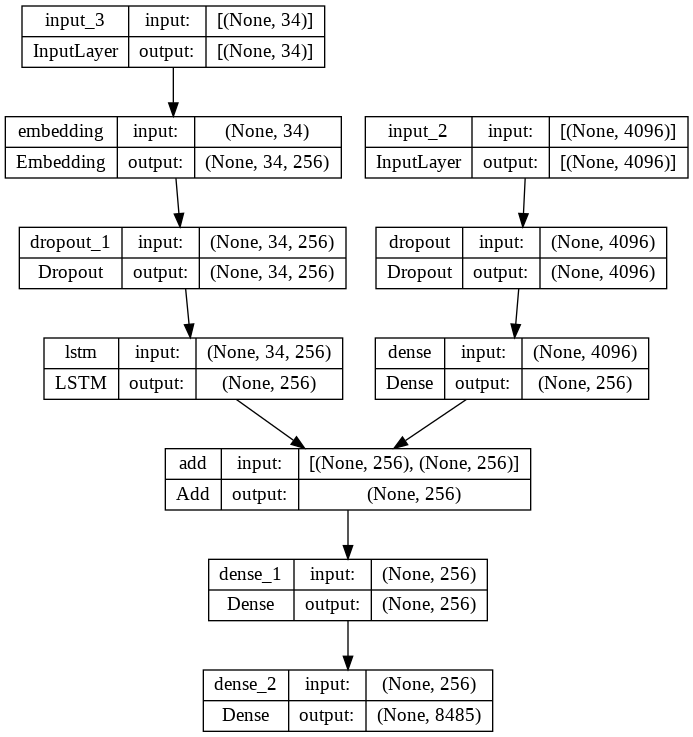

In [ ]:
# encoder model

# image feature layers
inputs1 = Input(shape=(4096,)) #taking input from output of fc 2 dense layer of vgg16
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) #mask zero as we are padding the  sequence
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

#shape=(4096,) - output length of the features from the VGG model

#Dense - single dimension linear layer array

#Dropout() - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

#model.compile() - compilation of the model

#loss=’sparse_categorical_crossentropy’ - loss function for category outputs

#optimizer=’adam’ - automatically adjust the learning rate for the model over the no. of epochs

#Model plot shows the concatenation of the inputs and outputs into a single layer

In [ ]:
#captions on lstm
#images feature extraxtion on vgg16

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 58s 256ms/step - loss: 2.2043


In [ ]:
#mapping['2258277193_586949ec62']

KeyError: ignored

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
# save the model
model.save_weights(WORKING_DIR+'/best_model_weights.h5')

Generate captions for images

In [ ]:
#helper function
def idx_to_word(integer, tokenizer): #model will give all output as indexes so converting indexs to words

    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'shirt': 35,
 'down': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'front': 47,
 'sitting': 48,
 'holding': 49,
 'up': 50,
 'field': 51,
 'small': 52,
 'by': 53,
 'large': 54,
 'green': 55,
 'one': 56,
 'group': 57,
 'yellow': 58,
 'her': 59,
 'walking': 60,
 'children': 61,
 'men': 62,
 'into': 63,
 'air': 64,
 'beach': 65,
 'near': 66,
 'mouth': 67,
 'jumps': 68,
 'another': 69,
 'for': 70,
 'street': 71,
 'runs': 72,
 'its': 73,
 'from': 74,
 'riding'

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
       
        #pad the sequence
        #pad_sequences - used for equal distribution of words in sentences filling the remaining spaces with zeros
        sequence = pad_sequences([sequence], max_length)
       
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
       
        # get index with high probability
        yhat = np.argmax(yhat)
       
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
       
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

#BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

#The reference text contains all the words appended from the captions data (actual_captions)

#A BLEU Score more than 0.4 is considered a good result, for a better score increase the no. of epochs accordingly.

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.545258
BLEU-2: 0.324117


In [ ]:
from PIL import Image #loading image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq collage of one person climbing cliff endseq
startseq group of people are rock climbing on rock climbing wall endseq
startseq group of people climbing rock while one man belays endseq
startseq seven climbers are ascending rock face whilst another man stands holding the rope endseq
startseq several climbers in row are climbing the rock while the man in red watches and holds the line endseq
--------------------Predicted--------------------
startseq collage of climbers on rock face endseq


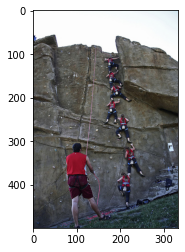

In [ ]:
generate_caption("1016887272_03199f49c4.jpg")

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq woman is sitting on bench in front of wooden playhouse endseq


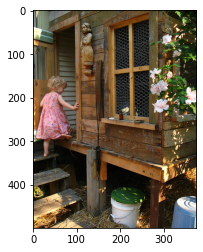

In [ ]:
generate_caption("1000268201_693b08cb0e.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pigtails is sitting on the grass with fingerpaints in the background endseq


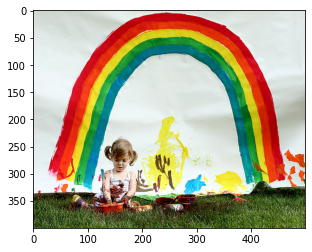

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man wearing red jacket and helmet is displaying sale on skis endseq


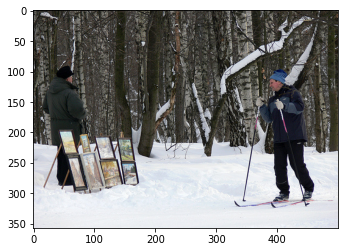

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq person stands near golden walls endseq
startseq woman behind scrolled wall is writing endseq
startseq woman standing near decorated wall writes endseq
startseq the walls are covered in gold and patterns endseq
startseq woman writing on pad in room with gold decorated walls endseq
--------------------Predicted--------------------
startseq two women are sitting on the street endseq


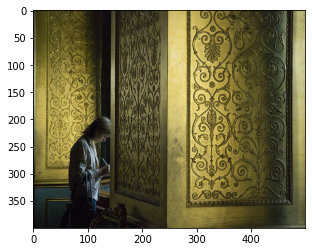

In [ ]:
generate_caption("997338199_7343367d7f.jpg")

---------------------Actual---------------------
startseq man in red biker suit on red dirt bike going down muddy road endseq
startseq man in red outfit is riding red motorbike uphill on motocross circuit endseq
startseq man in red riding gear riding dirt bike down path endseq
startseq man riding dirt bike up muddy hill endseq
startseq motorcycle racer in red jumpsuit and helmet rides up dirt hill endseq
--------------------Predicted--------------------
startseq man in red and red uniform riding bike endseq


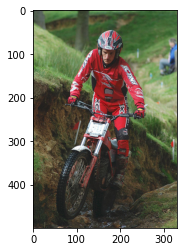

In [ ]:
generate_caption("1252396628_eb81d3905b.jpg")

---------------------Actual---------------------
startseq group is sitting around snowy crevasse endseq
startseq group of people sit atop snowy mountain endseq
startseq group of people sit in the snow overlooking mountain scene endseq
startseq five children getting ready to sled endseq
startseq five people are sitting together in the snow endseq
--------------------Predicted--------------------
startseq two men ride sled on snowmobile endseq


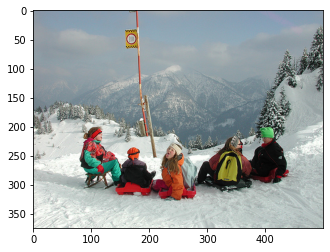

In [ ]:
generate_caption("99171998_7cc800ceef.jpg")

In [ ]:
#If we add our own image in the 8k dataset with caption then we can presict the caption for that image as well

---------------------Actual---------------------
startseq boy in black helmet and red long sleeve shirt rides his motorbike over rocky stream endseq
startseq man on motorcycle steers through swampy terrain endseq
startseq man rides his bike over rocks and creek endseq
startseq motocross bike is being ridden between markers in running stream endseq
startseq person is dirt biking over rocks and water endseq
--------------------Predicted--------------------
startseq man in red shirt and black headband is riding bike through stream endseq


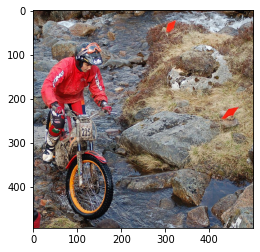

In [ ]:
generate_caption("143552829_72b6ba49d4.jpg")

---------------------Actual---------------------
startseq bike sits atop rise with mountains in the background endseq
startseq man wearing red uniform and helmet stands on his motorbike endseq
startseq motocross bike is being ridden over rocks endseq
startseq motocross biker about to descend endseq
startseq the motorcyclist has reached the summit endseq
--------------------Predicted--------------------
startseq man in red and black biking gear rides his bike endseq


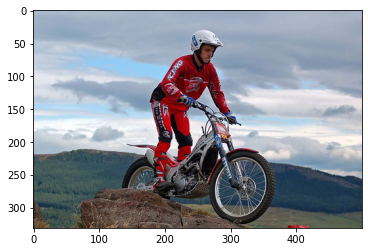

In [ ]:
generate_caption("216172386_9ac5356dae.jpg")

---------------------Actual---------------------
startseq boy in yellow uniform carrying football is blocking another boy in blue uniform endseq
startseq football player in yellow jersey is pushing away another player endseq
startseq the young football player is trying to avoid being tackled endseq
startseq two boys playing football on opposing teams endseq
startseq two young football players wearing blue and yellow uniforms fight for the ball endseq
--------------------Predicted--------------------
startseq two men in blue and white uniforms are playing in field endseq


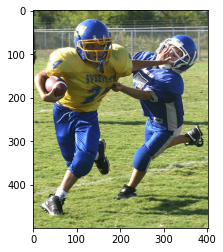

In [ ]:
generate_caption("2526041608_a9775ab8d7.jpg")

---------------------Actual---------------------
startseq boy in yellow uniform carrying football is blocking another boy in blue uniform endseq
startseq football player in yellow jersey is pushing away another player endseq
startseq the young football player is trying to avoid being tackled endseq
startseq two boys playing football on opposing teams endseq
startseq two young football players wearing blue and yellow uniforms fight for the ball endseq
--------------------Predicted--------------------
startseq two men in blue and white uniforms are playing in field endseq


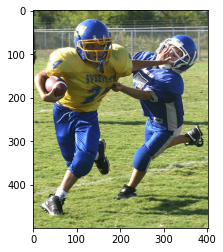

In [ ]:
generate_caption("2526041608_a9775ab8d7.jpg")